**7 Combining Different Models for Ensemble Learning**  
    **Goal**:
- Make predictions based on majority voting
- Use bagging to reduce overfitting by drawing random combinations of training dataset with repetition
- Apply boosting to build powerful models from weak learner that learn from their mistakes

# Learning with ensembles

*ensemble method* is about combining classifiers to predict rather than just one classifier. In this chapter, the focus is **majority voting**, which choose the most voted class (more than 50).

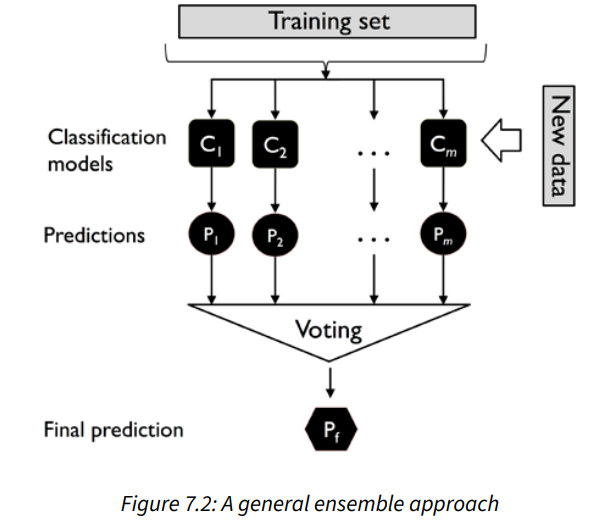

**Why classifiers make more accurate prediction more than one classifier?**. Make an assumption is that all the classifiers have the same error rate $\varepsilon$. So the probability of choosing wrong prediction is: 
$$P(y \geq k) = \sum_{k}^{n} \binom{n}{k} \, \varepsilon^k (1-\varepsilon)^{n-k}$$ 
Take a concrete example, a model has 11 classifiers, each classifier has $\epsilon = 0.25$, so
$$F(k) = \sum_{k=6}^{11} \binom{11}{k} \, \varepsilon^k (1 - \varepsilon)^{n-k} \approx 0.034$$
That's very very small compared to just one classifier

In [1]:
#implement CDF of ensemble error
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * 
    (1-error)**(n_classifier - k)
    for k in range(k_start, n_classifier + 1)]
    return sum(probs)
    

In [2]:
ensemble_error(n_classifier = 11, error = 0.25)

np.float64(0.03432750701904297)

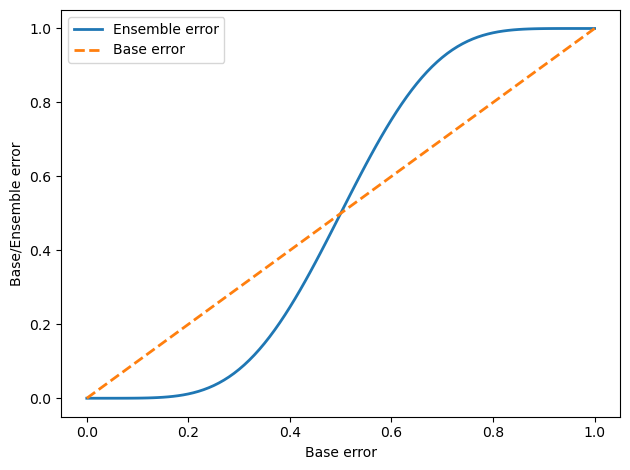

In [3]:
#draw graph for each value of e
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier = 11, error = error) for error in error_range]
plt.plot(error_range, ens_error, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, label = 'Base error', linestyle = '--', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend()
plt.tight_layout()
plt.show()

# Combining classifiers via majority vote

## Implementing a simple mojority vote classifier

There's disadvantage in ensemble learning above, if model is highly non-linear, so linear model's result don't trust worthy, and maybe SVC is a more worthy classifier, so there's weighted version:
$$\hat{y} = \arg\max_{i} \sum_{j=1}^{m} w_j \chi_{A}(C_j(x) = i)$$ 
$\chi_{A}(C_j(x) = i)$ is indicator, it equal to 1 if $C_j(x) = i$ else 0

In [4]:
import numpy as np
np.argmax(np.bincount([0,0,1], weights = [0.2,0.2,0.6]))

np.int64(1)

The modified version of majority vote for predicting class using probability:
$$ \hat{y} = \arg\max_{i} \sum_{j=1}^{m} w_{j}p_{ij}$$

In [5]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


np.int64(0)

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' "
                             f"or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and \
                len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                             f' weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([
                clf.predict(X) for clf in self.classifiers_
            ]).T

            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(
                    np.bincount(x, weights=self.weights)
                ),
                axis=1, arr=predictions
            )
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
                               weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(
                        deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


## Using the majority voting principle to make predictions

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y, random_state = 1)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty = 'l2', 
                          C=0.001,
                          solver = 'lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion = 'entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric= 'minkowski')
pipe1=Pipeline([['sc', StandardScaler()],
                ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


10-fold cross validation: 

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [10]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: nan (+/- nan) [Majority voting]


D:\ap\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response_method, **kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "D:\ap\Lib\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
   

## Evaluating and tuning the ensemble classifier

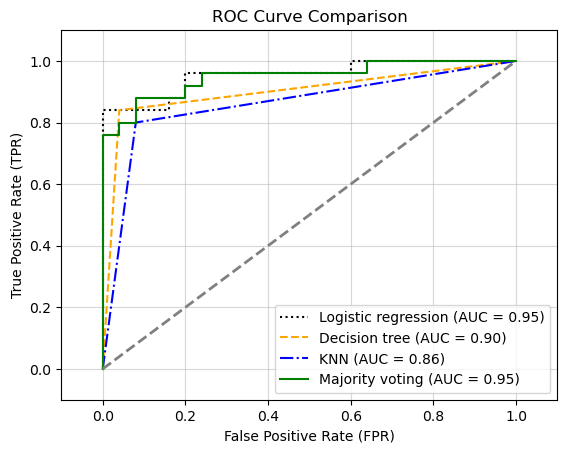

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example lists (make sure these are defined in your code)
# all_clf = [clf1, clf2, clf3, clf4]
# clf_labels = ['Classifier 1', 'Classifier 2', 'Classifier 3', 'Classifier 4']

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # Assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (AUC = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.show()


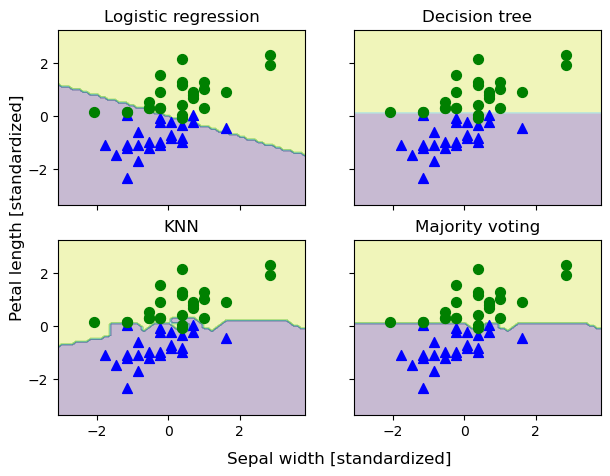

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()


**Note:** *Majority voting* is hybrid of 3 models.

In [13]:
# how to access individuals param
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [18]:
from sklearn.model_selection import GridSearchCV

params = {
    'decisiontreeclassifier__max_depth': [1, 2],
    'pipeline-1__clf__C': [0.001, 0.1, 100.0]
}

grid = GridSearchCV(
    estimator=mv_clf,
    param_grid=params,
    cv=10,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)


D:\ap\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\ap\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "D:\ap\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

In [21]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')


nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
nan +/- nan {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [20]:
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC : {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC : nan


# Bagging - building an ensemble of classifiers from bootstrap samples
Bagging is an ensemble learning technique that is closely related to the MajorityVoteClassifier. However, instead of using the same training dataset to fit the individual classifiers in the ensemble, we draw **bootstrap** samples (random samples with replacement) from the initial training dataset.
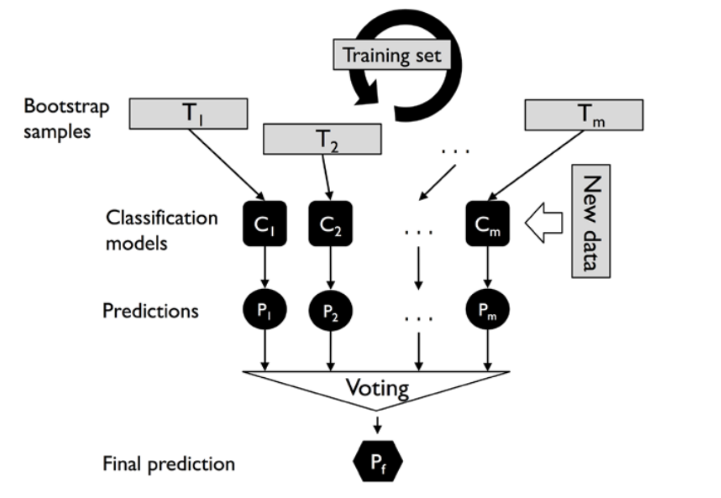

## Bagging in a nutshell

Already learned

## Applying bagging to classify example s in the Wine dataset

In [22]:
import pandas as pd

df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None
)

df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
    'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins', 'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1,
    stratify=y
)


In [26]:
# using Bagging in sklearn
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(
    criterion='entropy',
    random_state=1,
    max_depth=None
)

bag = BaggingClassifier(
    estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1
)


In [30]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies {tree_train:.3f}/{tree_test:.3f}')


Decision tree train/test accuracies 1.000/0.833


In [31]:
# Fit the bagging model
bag = bag.fit(X_train, y_train)

# Make predictions
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

# Compute accuracies
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

# Print train/test accuracies
print(f'Bagging train/test accuracies {bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


**Comment:** Only one unpruned tree is not effectively predict as bagging model
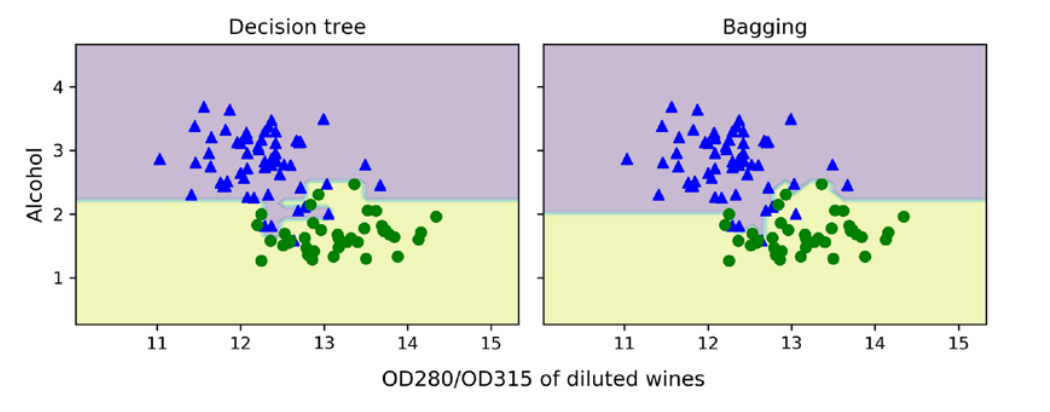

# Leveraging weak leaners via adaptive boosting
In boosting, emsemble consists of simple learning model, which may have slightly better performance than random guess 

## How adaptive boosting works
Boosting Procedure (Original Formulation):
1. Draw a random subset of training examples, $d_1 \subset D$, **without replacement** from the training dataset $D$ to train a weak learner $C_1$.
2. Draw a second random training subset, $d_2$, without replacement from the training dataset and add 50 percent of the examples that were previously misclassified to train a weak learner, $C_2$.
3. Find the training examples, $d_3$, in the training dataset, $D$, which $C_1$ and $C_2$ disagree upon, to train a third weak learner, $C_3$.
4. Combine all weak learners $(C_1, C_2, C_3)$ using **majority voting** (for classification) or averaging (for regression).

*Visualization of Adaptive boosting:*

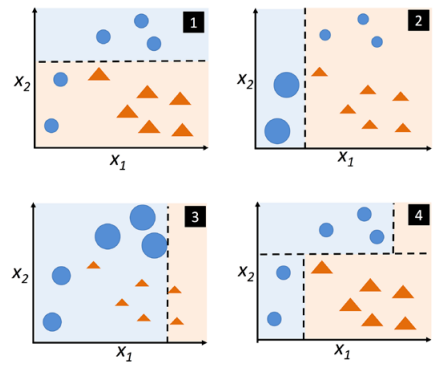

## Applying AdaBoost using scikit-learn

In [33]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',
                              random_state = 1,
                              max_depth = 1)
ada =AdaBoostClassifier(estimator=tree,
                        n_estimators = 500,
                        learning_rate = .1,
                        random_state = 1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('tree_train ', tree_train)
print('tree_test ', tree_test)

tree_train  0.9157894736842105
tree_test  0.875


In [34]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f"AdaBoost train/test accuracies {ada_train:.3f}/{ada_test:.3f}")


AdaBoost train/test accuracies 0.968/0.917


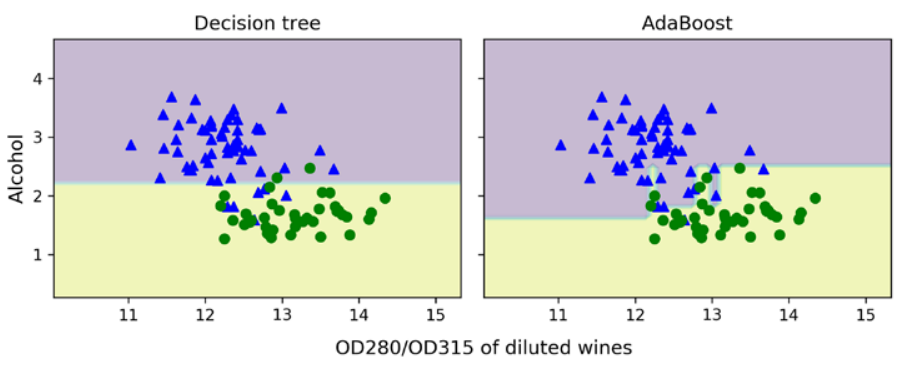

Although *adaptive boosting* increases the accuracy, it also increases the computational cost. We have to answer the question: Do we want to make this trade-off between the computational cost and a slight improvement in the result? 

# Gradient boosting - training an ensemble based on loss gradients

## Comparing AdaBoost with gradient boosting
Gradient Boosting vs. AdaBoost – Key Differences and Similarities:

*Similarities:*
1. Both are ensemble methods that build models iteratively.
2. Both use decision trees and base each new tree on the errors of the previous ones.

*AdaBoost:*

1. Uses decision tree stumps (very shallow trees).
2. Assigns sample weights based on previous errors.
3. Combines trees using individual weights per tree.
4. Training stops after a set number of iterations (trees).

*Gradient Boosting:*

1. Uses deeper trees (depth 3–6 or 8–64 leaf nodes).
2. Uses errors to create a new target variable, not sample weights.
3. Applies a global learning rate instead of individual tree weights.

## Outlining the general gradient boosting algorithm

## Explaining the gradient boosting algorithm for classification

## Illustrating gradient boosting for classification

## Using XGBoost

# Summary

Chapter Summary: Ensemble Learning

Ensemble Methods: Combine multiple models to reduce individual weaknesses and improve performance. Popular in industry and competitions.

MajorityVoteClassifier: A Python implementation that combines different classifiers using majority voting.

Bagging:

Reduces variance.

Uses bootstrap samples (random sampling with replacement).

Aggregates results through majority vote (e.g., Random Forest).

Boosting:

Reduces bias.

Trains weak learners sequentially.

Each model learns from the errors of the previous one.

Includes AdaBoost and Gradient Boosting.

Context:

Builds on previous chapters about algorithms, tuning, and evaluation.

Prepares for the next chapter: Sentiment Analysis — a key ML application in social media and internet text analysis.